In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import librosa
import os
import torch.optim as optim
from torch.optim import lr_scheduler

In [31]:
RANDOM_SEED=74
torch.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Audio Preprocessing

In [6]:
def LoadFile(file_path, duration):
    #LOADS THE FILE 
    audio, sr = librosa.load(file_path, duration=duration)
    
    return audio

In [ ]:
def GetSpec(audio, hop_size, frame_size):
    spec = librosa.stft(audio, hop_length=hop_size, n_fft=frame_size)
    spec_reals = spec.real
    spec_imag = spec.imag
    spec_reals = spec_reals[np.newaxis, ...]
    spec_imag = spec_imag[np.newaxis, ...]
    data = np.concatenate((spec_reals, spec_imag), axis=0)
    
    return data

In [8]:
def NormaliseData(data, db_data):

    sig = np.std(db_data)
    
    #print(sig)
    norm_data = data / sig
    #print(norm_data.shape)
    
    return norm_data, sig

In [9]:
def ApplyRightPadding(audio_array, size):
    padding = np.array([0 for _ in range(size)])
    audio_array = np.concatenate((audio_array, padding), axis=0)
    
    return audio_array

In [10]:
def DenormalizeData(spec, sig):
    original_spec = spec * sig 
    
    return original_spec
    

In [11]:
def FreqToDB(spec):
    real_part = spec[0]
    imag_part = spec[1]
    db_real_spec = librosa.amplitude_to_db(real_part)
    db_imag_spec = librosa.amplitude_to_db(imag_part)
    
    return db_real_spec, db_imag_spec
    

In [12]:
def ISTFT(spec, hop_size):
    audio = librosa.istft(spec, hop_length=hop_size)
    
    return audio

In [13]:
def SaveData(data, save_dir, file_name):
    np.save(os.path.join(save_dir, file_name), data)

In [16]:
def PreprocessAudioData(path_to_dir, duration, sr, frame_size, hop_size, save_dir):
    data = []
    data_db = []
    
    for root, _ , files in os.walk(path_to_dir):
        for file in files:
            path = os.path.join(root, file)
            audio = LoadFile(path, duration)
            
            if audio.shape[0] < duration * sr:
                size = duration * sr - audio.shape[0]
                audio = ApplyRightPadding(audio, size)
            
            data_sample = GetSpec(audio, HOP_SIZE, FRAME_SIZE)
            data.append(data_sample)
            real_db, imag_db = FreqToDB(data_sample)
            real_db = real_db[np.newaxis, ...]
            imag_db = imag_db[np.newaxis, ...]
            data_sample_db = np.concatenate((real_db, imag_db), axis=0)
            data_db.append(data_sample_db)
            
    data = np.array(data)
    data_db = np.array(data_db)
    #data, sigma = NormaliseData(data, data_db)
    #SaveData(data, save_dir, 'data.npy')
    
    return data, data_db

In [15]:
def ReconstructSignal(spec, hop_size, sig):
    original_spec = DenormalizeData(spec, sig)
    original_spec = original_spec[0] + 1j * original_spec[1]
    audio = ISTFT(original_spec, hop_size=hop_size)
    return audio

In [29]:
def FindAllDir(root):
    dirs = []
    for root, direct, files in os.walk(root):
        dirs.append(direct)
    
    return dirs

In [36]:
DURATION = 2
FRAME_SIZE = 512
HOP_SIZE = 256
SAMPLE_RATE = 22050
PATH_TO_DIR = './vcc2018_training'
SAVE_DIR = './save_dir'

In [43]:
dirs = FindAllDir(PATH_TO_DIR)[0][1:]
data = []
data_db = []
for dir in dirs:
    PATH = os.path.join(PATH_TO_DIR, dir)
    bunch, bunch_db = PreprocessAudioData(PATH, DURATION, SAMPLE_RATE, FRAME_SIZE, HOP_SIZE, SAVE_DIR)
    data.append(bunch)
    data_db.append(bunch_db)
data = np.array(data)
data_db = np.array(data_db)
data, SIGMA = NormaliseData(data, data_db)


16.559638690716934
(12, 81, 2, 257, 173)


In [44]:
data = data.reshape((972, 2, 257, 173))
data.shape

(972, 2, 257, 173)

In [45]:
np.save(os.path.join(SAVE_DIR, 'data'), data)

# Dataset


In [98]:
class AudioDataset(Dataset):
    def __init__(self, data):
        self.x = torch.from_numpy(data).type(torch.FloatTensor)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, ind):
        return self.x[ind]

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(data, test_size=0.2, shuffle=True)

In [100]:
x_train = AudioDataset(x_train)
x_val = AudioDataset(x_val)

In [292]:
BATCH_SIZE = 128

train_dataloader = DataLoader(x_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(x_val, batch_size=BATCH_SIZE, shuffle=False)

In [293]:
x_train.x.shape

torch.Size([777, 2, 257, 173])

# AutoEncoder Model

In [294]:
class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=16, 
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32)
        )
        self.seq3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64)
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128)
        )
        self.flat = nn.Flatten()
            #Bottleneck
        self.lin = nn.Linear(in_features=17*11*128, out_features=output_size)
            
        
        
    def forward(self, X):
        #print('e_original:', X.shape)
        X = self.seq1(X)
        #print('e_seq1:', X.shape)
        X = self.seq2(X)
        #print('e_seq2:', X.shape)
        X = self.seq3(X)
        #print('e_seq3:', X.shape)
        X = self.seq4(X)
        #print('e_seq4:', X.shape)
        X = self.flat(X)
        #print('e_flat:', X.shape)
        X = self.lin(X)
        #print('e_lin:', X.shape)
        return X

In [295]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features= 17*11*128),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=17*11*128)
        )
        self.unflat = nn.Unflatten(dim=1, unflattened_size=(128, 17, 11))
        self.seq2 = nn.Sequential(   
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64)
        )
        self.seq3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                               kernel_size=3, stride=2, padding=1, output_padding=(0, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32)
        )
        self.seq4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, 
                               kernel_size=3, stride=2, padding=1, output_padding=(0,0)),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16)
        )
        self.conv = nn.ConvTranspose2d(in_channels=16, out_channels=output_size, 
                               kernel_size=3, stride=2, padding=1, output_padding=(0,0))
            
        
        
    def forward(self, X):
        #print('after encoder:', X.shape)
        X = self.seq1(X)
        #print('d_seq1:', X.shape)
        X = self.unflat(X)
        #print('d_unflat:', X.shape)
        X = self.seq2(X)
        #print('d_seq2:', X.shape)
        X = self.seq3(X)
        #print('d_seq3:', X.shape)
        X = self.seq4(X)
        #print('d_seq4:', X.shape)
        X = self.conv(X)
        #print('result:', X.shape)
        return X

In [296]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        X = self.encoder(X)
        #print(X.shape)
        return self.decoder(X)

In [297]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [364]:
DATA_SAMPLE_SIZE = 2*257*173
LATENT_SHAPE = 64
encoder = Encoder(input_size=DATA_SAMPLE_SIZE, output_size=LATENT_SHAPE)
encoder.to(device)
decoder = Decoder(input_size=LATENT_SHAPE, output_size=2)
decoder.to(device)
autoencoder = AutoEncoder(encoder=encoder, decoder=decoder)
autoencoder.to(device)

AutoEncoder(
  (encoder): Encoder(
    (seq1): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (seq2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (seq3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (seq4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (flat): Flatten(start_dim=1, end_dim=-1)
    (lin): Linear(in_features=23936, out_features=64, b

In [365]:
model_total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 3330850


# Loss-function and optimizer

In [366]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.001)

# Train Loop

In [367]:
def train(model, criterion, optimizer,
          train_dataloader, val_dataloader, num_epochs, prev_best_val_loss=None):
    if prev_best_val_loss is None:
        best_val_loss = torch.inf
    else:
        best_val_loss = prev_best_val_loss

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f}"

    train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    
    with tqdm(desc="epoch", total=num_epochs) as pbar_outer:
        for i_epoch in range(num_epochs):
            train_loss = 0
            val_loss = 0

            # train step
            model.train()
            for batch in tqdm(train_dataloader):
                X = batch.to(device)

                # model forward-pass
                preds = autoencoder(X)

                # model backward-pass
                optimizer.zero_grad()
                loss = criterion(preds, X)
                loss.backward()
                optimizer.step()

                # save loss and accuracy
                train_loss += loss.detach().cpu().numpy()

            train_loss /= len(train_dataloader)
            train_losses[i_epoch] = train_loss


            # test step
            model.eval()
            for batch in val_dataloader:
                X = batch.to(device)
                #print(X.shape)
                with torch.no_grad():
                    # model forward-pass
                    preds = autoencoder(X)
                    #print(preds.shape)
                    loss = criterion(preds, X)

                    # save loss and accuracy
                    val_loss += loss.detach().cpu().numpy()

            val_loss /= len(val_dataloader)
            val_losses[i_epoch] = val_loss
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss

                torch.save({
                            'epoch': i_epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_loss,
                            }, SAVE_DIR + 'best_checkpoint.pth')

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i_epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss))

    return train_losses, val_losses

In [368]:
train_losses, val_losses = train(model=autoencoder, criterion=criterion, optimizer=optimizer,
                                train_dataloader=train_dataloader, val_dataloader=val_dataloader, num_epochs=50)

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 001 train_loss: 0.5864     val_loss 0.0163


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2567     val_loss 0.0174


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.1263     val_loss 0.0229


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0755     val_loss 0.0297


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0477     val_loss 0.0273


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.0329     val_loss 0.0213


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.0238     val_loss 0.0153


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.0181     val_loss 0.0113


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.0141     val_loss 0.0087


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.0114     val_loss 0.0071


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 011 train_loss: 0.0096     val_loss 0.0061


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 012 train_loss: 0.0084     val_loss 0.0055


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 013 train_loss: 0.0074     val_loss 0.0052


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 014 train_loss: 0.0067     val_loss 0.0050


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 015 train_loss: 0.0062     val_loss 0.0050


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 016 train_loss: 0.0058     val_loss 0.0050


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 017 train_loss: 0.0055     val_loss 0.0049


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 018 train_loss: 0.0052     val_loss 0.0047


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 019 train_loss: 0.0049     val_loss 0.0046


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 020 train_loss: 0.0047     val_loss 0.0045


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 021 train_loss: 0.0046     val_loss 0.0044


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 022 train_loss: 0.0044     val_loss 0.0043


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 023 train_loss: 0.0043     val_loss 0.0042


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 024 train_loss: 0.0042     val_loss 0.0042


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 025 train_loss: 0.0041     val_loss 0.0041


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 026 train_loss: 0.0040     val_loss 0.0040


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 027 train_loss: 0.0039     val_loss 0.0040


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 028 train_loss: 0.0039     val_loss 0.0039


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 029 train_loss: 0.0038     val_loss 0.0038


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 030 train_loss: 0.0037     val_loss 0.0038


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 031 train_loss: 0.0037     val_loss 0.0038


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 032 train_loss: 0.0036     val_loss 0.0037


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 033 train_loss: 0.0036     val_loss 0.0037


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 034 train_loss: 0.0036     val_loss 0.0037


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 035 train_loss: 0.0035     val_loss 0.0037


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 036 train_loss: 0.0035     val_loss 0.0037


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 037 train_loss: 0.0035     val_loss 0.0036


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 038 train_loss: 0.0034     val_loss 0.0036


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 039 train_loss: 0.0034     val_loss 0.0036


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 040 train_loss: 0.0034     val_loss 0.0035


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 041 train_loss: 0.0033     val_loss 0.0035


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 042 train_loss: 0.0033     val_loss 0.0035


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 043 train_loss: 0.0033     val_loss 0.0035


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 044 train_loss: 0.0033     val_loss 0.0035


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 045 train_loss: 0.0033     val_loss 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 046 train_loss: 0.0032     val_loss 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 047 train_loss: 0.0032     val_loss 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 048 train_loss: 0.0032     val_loss 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 049 train_loss: 0.0032     val_loss 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 050 train_loss: 0.0032     val_loss 0.0034


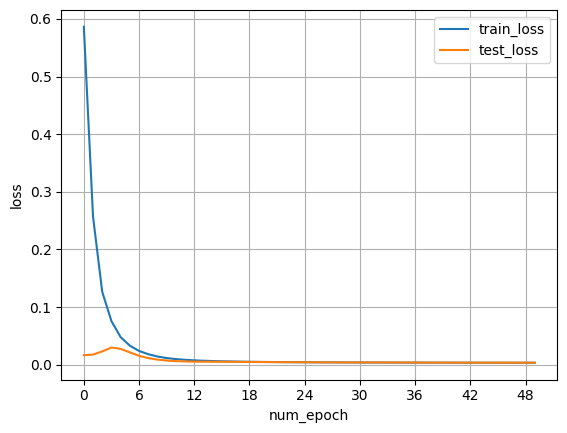

In [369]:


plt.plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
plt.plot(np.arange(val_losses.shape[0]), val_losses, label='test_loss')
plt.xticks(np.arange(0, train_losses.shape[0], 6))
plt.xlabel('num_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# Audio Reconstruction

In [372]:
from random import randint
test = [randint(0, 972) for _ in range(5)]
test

[436, 437, 724, 270, 517]

In [373]:
def PredictSample(input_data):
    with torch.no_grad():
        model_input = torch.tensor(input_data).type(torch.FloatTensor).unsqueeze(0).to(device)
        pred = autoencoder(model_input).squeeze().cpu().numpy()
        print(pred.shape)
    audio = ReconstructSignal(spec=pred, hop_size=HOP_SIZE, sig=SIGMA)
    return audio

In [374]:
audio = PredictSample(data[test[0]])
audio.shape

(2, 257, 173)


(44032,)

In [375]:
import IPython.display as ipd

In [376]:
reconstructed_audio = []
original_audio = []
for num in test:
    r_audio = PredictSample(data[num])
    o_audio = ReconstructSignal(spec=data[num], hop_size=HOP_SIZE, sig=SIGMA)
    reconstructed_audio.append(r_audio)
    original_audio.append(o_audio)


(2, 257, 173)
(2, 257, 173)
(2, 257, 173)
(2, 257, 173)
(2, 257, 173)


In [377]:
ipd.Audio(original_audio[1], rate=SAMPLE_RATE)

In [378]:
ipd.Audio(reconstructed_audio[1], rate=SAMPLE_RATE)